In [1]:
# Making data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.datasets import make_circles

n_samples = 1000
torch.manual_seed(42)

X, y = make_circles(n_samples, noise=0.03, random_state=42)
# X and y are numpy arrays. So, wer converted them into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
print("Features:\n", X[:5])
print("Labels:\n", y[:5])

Features:
 tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])
Labels:
 tensor([1., 1., 1., 1., 0.])


The function make_circles() automatically generates both:

X: the feature matrix → 1000 points in 2D space

y: the label vector → class label (0 or 1) for each point

In [2]:
# Making a Data Frame from the circle data
circles = pd.DataFrame({"X1" : X[:, 0],
                        "X2" : X[:, 1],
                        "label" : y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1.0
1,-0.756159,0.153259,1.0
2,-0.815392,0.173282,1.0
3,-0.393731,0.692883,1.0
4,0.442208,-0.896723,0.0


In [3]:
circles.label.value_counts()

,count
label,
1.0,500
0.0,500


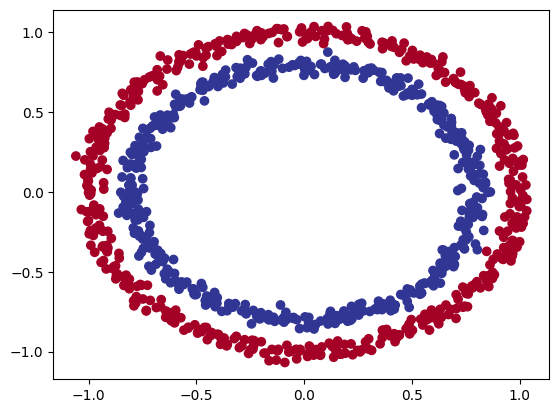

In [4]:
# Visualizing the data
plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu)

In [5]:
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [6]:
X_sample = X[0]
y_sample = y[0]
print(X_sample, y_sample)
print(X_sample.shape, y_sample.shape)
# This tells us that X is a vector as it has 2 dimensions whereas y has one feature so it is a scalar

tensor([0.7542, 0.2315]) tensor(1.)
torch.Size([2]) torch.Size([])


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### Building a Model

In [8]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
# Building an ANN
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2,
                             out_features = 15)
    self.relu1 = nn.ReLU()
    self.layer_2 = nn.Linear(in_features = 15,
                             out_features = 15)
    self.relu2 = nn.ReLU()
    self.layer_3 = nn.Linear(in_features = 15,
                             out_features = 1)

  def forward(self, x):
    x = self.relu1(self.layer_1(x))
    x = self.relu2(self.layer_2(x))
    x = self.layer_3(x)
    return x
    # Solves layer_1 and its resultant is passed to layer_2

In [10]:
model = CircleModel().to(device)
model

CircleModel(
  (layer_1): Linear(in_features=2, out_features=15, bias=True)
  (relu1): ReLU()
  (layer_2): Linear(in_features=15, out_features=15, bias=True)
  (relu2): ReLU()
  (layer_3): Linear(in_features=15, out_features=1, bias=True)
)

In [11]:
# Sequential can be used instead of the class above
"""
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0
"""
print(X_train.shape)
print(X_test.shape)

torch.Size([800, 2])
torch.Size([200, 2])


In [12]:
with torch.inference_mode():
  y_pred = model(X_test.to(device))
print(f"Length of predictions : {len(y_pred)}, Shape : {y_pred.shape}")
print(f"Length of test samples : {len(y_test)}, Shape : {y_test.shape}")
print(f"\nFirst 10 predictions:\n{y_pred[:10]}")
#y_test = y_test.unsqueeze(dim = 1)
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions : 200, Shape : torch.Size([200, 1])
Length of test samples : 200, Shape : torch.Size([200])

First 10 predictions:
tensor([[-0.0267],
        [ 0.0155],
        [-0.1023],
        [ 0.0104],
        [-0.0320],
        [-0.0332],
        [-0.0582],
        [-0.0555],
        [-0.1033],
        [ 0.0174]], device='cuda:0')

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [13]:
loss_fn = nn.BCEWithLogitsLoss() # Uses the sigmoid function (Better for probabilities)
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.1)

# Evaluation Metric for accuracy

In [14]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [15]:
# Forward pass - full test set
with torch.inference_mode():
  # To.device send the model to train in the gpu unit as it is fater compared to the cpu
    y_logits = model(X_test.to(device))  # We obtain the logits
    y_pred_probs = torch.sigmoid(y_logits) # We find the probabilities from the obtained logits through the sigmoid function
    y_pred_labels = torch.round(y_pred_probs) # We're rounding off the probabilities

    """
The goal of this block is to:

✅ Understand what your model is outputting.
✅ See the raw model output (logits).
✅ Convert logits to probabilities → using sigmoid.
✅ Convert probabilities to predicted labels → using round.
    """

# Check shapes
print(f"y_pred_labels shape: {y_pred_labels.shape}")
print(f"y_test shape: {y_test.shape}")

# Squeeze both for comparison (if needed)
y_pred_labels_temp = y_pred_labels.squeeze()
y_test_temp = y_test.to(device).squeeze()

# Check equality
print(torch.eq(y_test_temp, y_pred_labels_temp))

# Print first 10 predictions and labels
print(f"\nFirst 10 predictions:\n{y_pred_labels_temp[:10]}")
print(f"\nFirst 10 test labels:\n{y_test_temp[:10]}")


y_pred_labels shape: torch.Size([200, 1])
y_test shape: torch.Size([200])
tensor([False, False, False, False, False, False,  True,  True, False, False,
         True, False,  True, False,  True, False, False,  True, False,  True,
        False,  True, False,  True,  True,  True,  True,  True,  True, False,
        False,  True,  True, False,  True, False, False, False, False, False,
        False, False, False,  True, False,  True,  True, False, False, False,
        False, False,  True,  True, False,  True, False, False, False,  True,
        False,  True,  True, False, False, False, False,  True, False,  True,
        False, False,  True, False, False, False, False,  True,  True, False,
         True, False,  True, False, False, False,  True,  True,  True,  True,
        False, False, False, False, False,  True, False, False,  True, False,
        False,  True, False, False,  True,  True, False,  True,  True, False,
        False, False,  True, False, False,  True, False,  True, Fals

### Training and Testing loop

In [16]:
epochs = 500

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model.train()

  # Forward passing
  y_logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculating loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss backwards
  loss.backward()

  # Optimizer step
  optimizer.step()

  # Testing
  model.eval()
  with torch.inference_mode():

    test_logits = model(X_test).squeeze( )
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
  if epoch % 20 == 0:
    print(f"Epoch : {epoch}  | Loss : {loss:.4f}  | Test Loss : {test_loss:.4f}")

Epoch : 0  | Loss : 0.6939  | Test Loss : 0.6839
Epoch : 20  | Loss : 0.1692  | Test Loss : 0.2416
Epoch : 40  | Loss : 0.0172  | Test Loss : 0.0345
Epoch : 60  | Loss : 0.0046  | Test Loss : 0.0136
Epoch : 80  | Loss : 0.0024  | Test Loss : 0.0081
Epoch : 100  | Loss : 0.0016  | Test Loss : 0.0065
Epoch : 120  | Loss : 0.0013  | Test Loss : 0.0058
Epoch : 140  | Loss : 0.0010  | Test Loss : 0.0053
Epoch : 160  | Loss : 0.0008  | Test Loss : 0.0050
Epoch : 180  | Loss : 0.0007  | Test Loss : 0.0046
Epoch : 200  | Loss : 0.0006  | Test Loss : 0.0042
Epoch : 220  | Loss : 0.0005  | Test Loss : 0.0039
Epoch : 240  | Loss : 0.0005  | Test Loss : 0.0036
Epoch : 260  | Loss : 0.0004  | Test Loss : 0.0035
Epoch : 280  | Loss : 0.0003  | Test Loss : 0.0032
Epoch : 300  | Loss : 0.0003  | Test Loss : 0.0030
Epoch : 320  | Loss : 0.0003  | Test Loss : 0.0028
Epoch : 340  | Loss : 0.0002  | Test Loss : 0.0026
Epoch : 360  | Loss : 0.0002  | Test Loss : 0.0022
Epoch : 380  | Loss : 0.0002  | Test 

In [17]:
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

<function matplotlib.pyplot.show(close=None, block=None)>

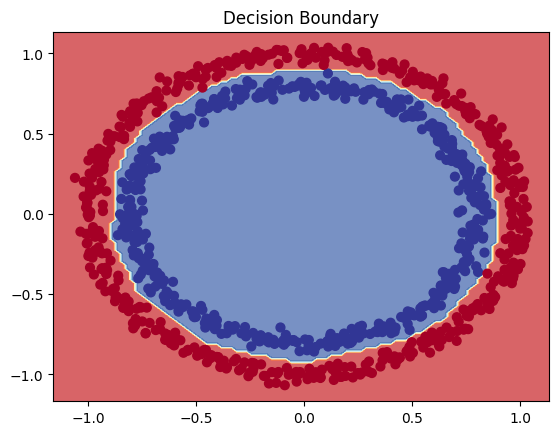

In [18]:
plot_decision_boundary(model, X, y)
plt.title("Decision Boundary")
plt.show